In [1]:
import pandas as pd
import gsw
import matplotlib.pyplot as plt

# Define test files
test_files = {
    "Test 3": "2025-04-29T14-31-17_second_down.csv",
    "Test 4": "2025-05-10T15-43-46_clean.csv",
    "Test 5": "2025-05-28T12-07-17_clean_one.csv",
    "Test 7": "2025-06-29T22-01-49_clean.csv",
    "Test 9": "2025-07-10T14-22-17_clean.csv"
}

# Location for GSW
latitude = 61
longitude = -150

# Store frequencies
sampling_frequencies = {}

# Store DataFrames if needed
dfs = {}

for label, fname in test_files.items():
    df = pd.read_csv(fname)
    df["time"] = pd.to_datetime(df["time"])
    
    # filter out negative depths
    df = df[df["slowBRDepth"] >= 0]

    # --- GSW Calculations ---
    df["pressure"] = df["slowBRPres"] / 100
    df["SA"] = gsw.SA_from_SP(df["sal"], df["pressure"], longitude, latitude)
    df["CT"] = gsw.CT_from_t(df["SA"], df["fastBRTemp"], df["pressure"])
    df["sigma0"] = gsw.sigma0(df["SA"], df["CT"])

    # calculate sampling frequency
    time_deltas = df["time"].diff().dt.total_seconds()
    avg_interval = time_deltas.mean()
    sampling_frequency_hz = 1 / avg_interval if avg_interval else 0
    sampling_frequencies[label] = sampling_frequency_hz
    dfs[label] = df

    print(f"{label}: {sampling_frequency_hz:.2f} Hz")

# overall average
all_freqs = list(sampling_frequencies.values())
overall_avg = sum(all_freqs) / len(all_freqs)
print(f"\nOverall average sampling frequency: {overall_avg:.2f} Hz")

Test 3: 4.98 Hz
Test 4: 4.98 Hz
Test 5: 4.98 Hz
Test 7: 5.02 Hz
Test 9: 5.06 Hz

Overall average sampling frequency: 5.00 Hz


C:\Users\sscop\AppData\Local\Temp\ipykernel_24288\3550666913.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


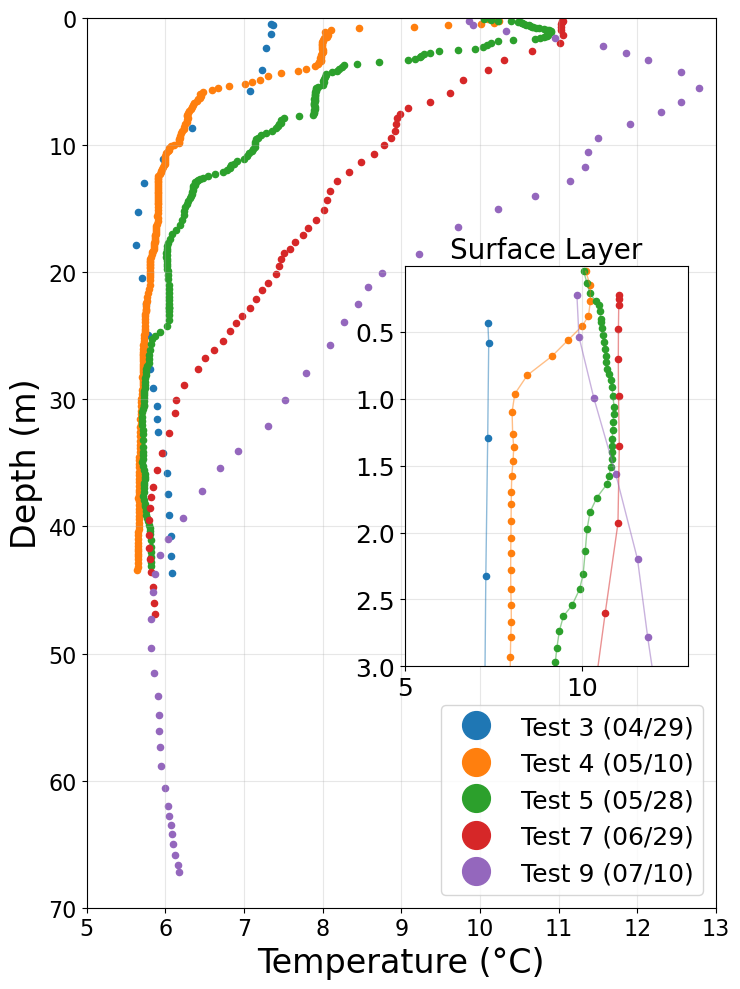

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.lines as mlines
import numpy as np  # Required for binning

size = 20

linewidth = 3
fig, ax = plt.subplots(figsize=(7.5, 10))

for label, df in dfs.items():
    if label == "Test 3":
        df = df.iloc[30:]

    # extract date from filename of this test
    fname = test_files[label]
    date_str = fname.split("T")[0]
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    date_fmt = dt.strftime("%m/%d")
    legend_label = f"{label} ({date_fmt})"

    # Bin average every 15 rows
    df_binned = df.groupby(np.arange(len(df)) // 15).agg({
        "fastBRTemp": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    ax.scatter(df_binned["fastBRTemp"], df_binned["slowBRDepth"], s=size, label=legend_label)

# main plot settings
ax.set_xlabel("Temperature (°C)", fontsize=24)
ax.set_ylabel("Depth (m)", fontsize=24)
ax.set_ylim(70, 0)
ax.set_xlim(5, 13)
ax.tick_params(labelsize=16)
ax.grid(alpha=0.3)

# Thicker legend markers
handles, labels = ax.get_legend_handles_labels()
new_handles = [mlines.Line2D([], [], color=h.get_facecolor()[0], marker='o', linestyle='None', markersize=10) for h in handles]
ax.legend(new_handles, labels, fontsize=18,markerscale=2)

# inset
axins = inset_axes(
    ax,
    width="45%",
    height="45%",
    loc="lower right",
    bbox_to_anchor=(0, 0.24, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=2,
)

for label, df in dfs.items():

    if label == "Test 3":
        df = df.iloc[30:]

    # Bin average every 15 rows
    df_binned = df.groupby(np.arange(len(df)) // 15).agg({
        "fastBRTemp": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    axins.scatter(df_binned["fastBRTemp"], df_binned["slowBRDepth"], s=size)
    axins.plot(df_binned["fastBRTemp"], df_binned["slowBRDepth"], linewidth=1,alpha=0.5)

axins.set_xlim(5, 13)
axins.set_ylim(3, .01)
axins.set_title("Surface Layer", fontsize=20)
axins.tick_params(labelsize=18)
axins.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("allTests_temp.jpg", dpi=600)


C:\Users\sscop\AppData\Local\Temp\ipykernel_24288\3831124827.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


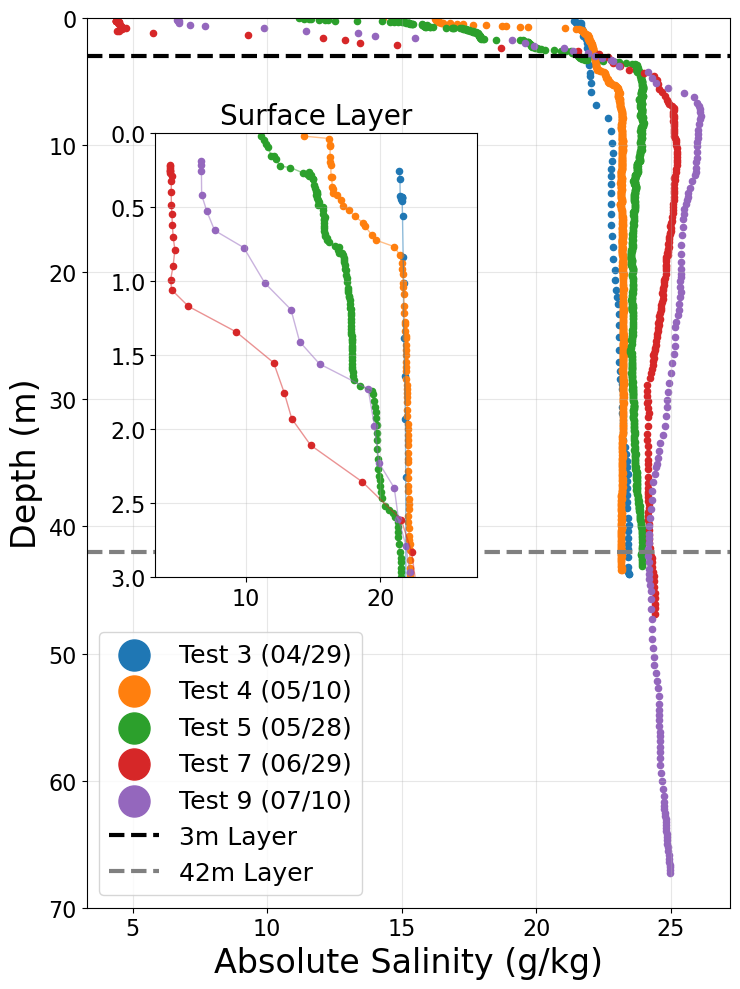

In [4]:
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(7.5, 10))

linewidth = 3  # added for consistency, though scatter ignores linewidth

for label, df in dfs.items():
    # Skip first two rows for Test 3 only
    if label == "Test 3":
        df = df.iloc[6:]

    # extract date from filename
    fname = test_files[label]
    date_str = fname.split("T")[0]
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    date_fmt = dt.strftime("%m/%d")
    legend_label = f"{label} ({date_fmt})"

    # Bin average every 5 rows
    df_binned = df.groupby(np.arange(len(df)) // 5).agg({
        "SA": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    ax.scatter(df_binned["SA"], df_binned["slowBRDepth"], s=size, label=legend_label)
    # ax.scatter(df["SA"], df["slowBRDepth"], s=3, label=legend_label)

# main plot
# fig.suptitle("", fontsize=20)
# ax.set_title("Absolute Salinity", fontsize=24)
# ax.set_title("All tests at Valdez Marine Terminal", fontsize=16)
ax.axhline(y=3, color='black', linewidth=linewidth, linestyle='--', label="3m Layer")
ax.axhline(y=42, color='gray', linewidth=linewidth, linestyle='--', label="42m Layer")
ax.set_xlabel("Absolute Salinity (g/kg)", fontsize=24)
ax.set_ylabel("Depth (m)", fontsize=24)
ax.set_ylim(70, 0)  # deeper at bottom
ax.tick_params(labelsize=16)
ax.grid(alpha=0.3)
ax.legend(fontsize=18, markerscale=5)

# inset
axins = inset_axes(
    ax,
    width="50%",
    height="50%",
    loc="lower right",
    bbox_to_anchor=(-0.35, 0.34, 1, 1),  # (x0, y0, width, height of bbox)
    bbox_transform=ax.transAxes,
    borderpad=2,
)

for label, df in dfs.items():
    if label == "Test 3":
        df = df.iloc[6:]

    df_binned = df.groupby(np.arange(len(df)) // 5).agg({
        "SA": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    axins.scatter(df_binned["SA"], df_binned["slowBRDepth"], s=size)
    axins.plot(df_binned["SA"], df_binned["slowBRDepth"], linewidth=1, alpha=0.5)
    # axins.scatter(df["SA"], df["slowBRDepth"], s=2)

axins.set_ylim(3, 0)          # zoom into 0–6 m
axins.set_title("Surface Layer", fontsize=20)
axins.tick_params(labelsize=16)
axins.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("allTests_salt.jpg", dpi=600)


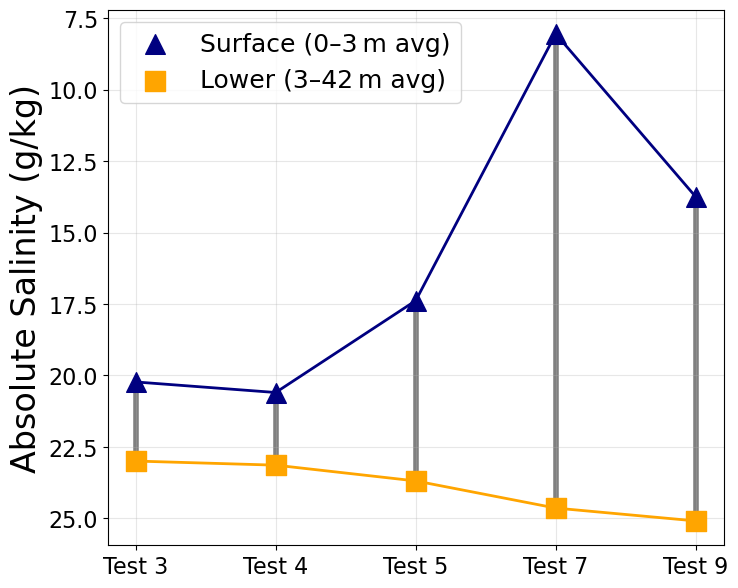

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from matplotlib.ticker import FormatStrFormatter
import numpy as np

# --- Data processing ---
results = []

for label, df in dfs.items():
    fname = test_files[label]
    date_str = fname.split("T")[0]
    dt = datetime.strptime(date_str, "%Y-%m-%d")

    surface_mask = (df["slowBRDepth"] >= 0) & (df["slowBRDepth"] <= 3)
    middle_mask = (df["slowBRDepth"] >= 3) & (df["slowBRDepth"] <= 42)

    surface_mean = df.loc[surface_mask, "SA"].mean()
    middle_mean = df.loc[middle_mask, "SA"].mean()
    stratification = middle_mean - surface_mean

    results.append({
        "Test": label,
        "Date": dt,
        "Surface_SA": surface_mean,
        "Middle_SA": middle_mean,
        "Stratification": stratification
    })

# --- Convert to DataFrame ---
strat_df = pd.DataFrame(results).sort_values("Date")

# Create numeric x positions and extract labels
x_vals = np.arange(len(strat_df))
labels = strat_df["Test"].tolist()
surface_vals = strat_df["Surface_SA"].values
middle_vals = strat_df["Middle_SA"].values

# CVD-friendly colors and markers
surface_color = 'navy'
lower_color = 'orange'
surface_marker = '^'
lower_marker = 's'

fig, ax = plt.subplots(figsize=(7.5, 6))

# Draw vertical gray lines for stratification
for i in range(len(strat_df)):
    ax.plot([x_vals[i], x_vals[i]], [surface_vals[i], middle_vals[i]],
            color='gray', linewidth=4, zorder=1)

# Draw connecting lines across tests
ax.plot(x_vals, surface_vals, color=surface_color, linewidth=2, zorder=2)
ax.plot(x_vals, middle_vals, color=lower_color, linewidth=2, zorder=2)

# Draw scatter points with clarified legend labels and markers
ax.scatter(x_vals, surface_vals, color=surface_color, s=200,
           marker=surface_marker, label='Surface (0–3 m avg)', zorder=3)
ax.scatter(x_vals, middle_vals, color=lower_color, s=200,
           marker=lower_marker, label='Lower (3–42 m avg)', zorder=3)

# Invert y-axis
ax.invert_yaxis()

# Axis labels and formatting
ax.set_ylabel("Absolute Salinity (g/kg)", fontsize=24)
# ax.set_xlabel("Test", fontsize=20)
ax.set_xticks(x_vals)
ax.set_xticklabels(labels)
ax.tick_params(labelsize=16)
ax.grid(alpha=0.3)

# Clean legend (no repeated entries)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=18)

plt.tight_layout()
plt.savefig("allTests_stratification_taller.jpg", dpi=600)

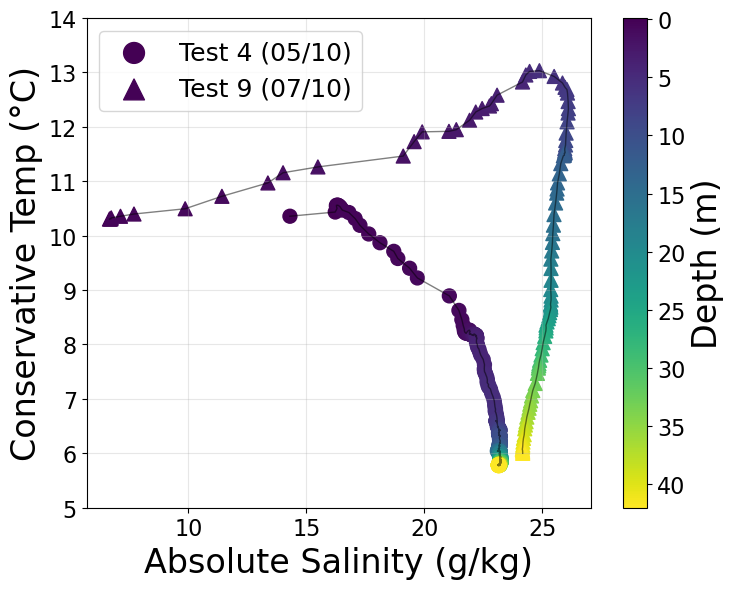

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.cm as cm
import matplotlib.colors as mcolors

test_labels = {
    "Test 4": "o",  # circle
    "Test 9": "^",  # triangle up
}

# Depth color scale (reversed)
depth_min, depth_max = 0, 42
norm = mcolors.Normalize(vmin=depth_max, vmax=depth_min)
cmap = cm.viridis

# Get max depth from Test 4 to limit Test 9
df4 = dfs["Test 4"].dropna(subset=["SA", "CT", "slowBRDepth"])
max_depth_test4 = df4["slowBRDepth"].max()

# Create plot
fig, ax = plt.subplots(figsize=(7.5, 6))

linewidth = 3  # for consistency with other plots

for label, marker in test_labels.items():
    df = dfs[label].dropna(subset=["SA", "CT", "slowBRDepth"])

    # Limit Test 9 depth
    if label == "Test 9":
        df = df[df["slowBRDepth"] <= max_depth_test4]

    # Extract date
    fname = test_files[label]
    date_str = fname.split("T")[0]
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    date_fmt = dt.strftime("%m/%d")
    legend_label = f"{label} ({date_fmt})"

    # Bin every 5 rows
    df_binned = df.groupby(np.arange(len(df)) // 5).agg({
        "SA": "mean",
        "CT": "mean",
        "slowBRDepth": "mean"
    }).reset_index(drop=True)

    # Scatter plot with depth color
    sc = ax.scatter(
        df_binned["SA"],
        df_binned["CT"],
        c=df_binned["slowBRDepth"],
        cmap=cmap,
        norm=norm,
        s=100,
        marker=marker,
        label=legend_label
    )

    # Optional black profile line
    ax.plot(
        df_binned["SA"],
        df_binned["CT"],
        linewidth=1,
        color="black",
        alpha=0.5
    )

# Axis formatting
ax.set_xlabel("Absolute Salinity (g/kg)", fontsize=24)
ax.set_ylabel("Conservative Temp (°C)", fontsize=24)
# ax.set_title("Seasonal Change - Tests 4 and 9", fontsize=24)
ax.set_ylim(5, 14)
ax.set_yticks(np.arange(5, 15, 1))
ax.tick_params(labelsize=16)
ax.grid(alpha=0.3)

# Colorbar formatting
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label("Depth (m)", fontsize=24)
cbar.ax.tick_params(labelsize=16)
cbar.ax.invert_yaxis()

# Legend formatting
ax.legend(fontsize=18, markerscale=1.5)

plt.tight_layout()
plt.savefig("TS_combined_Test4_Test9.jpg", dpi=600)


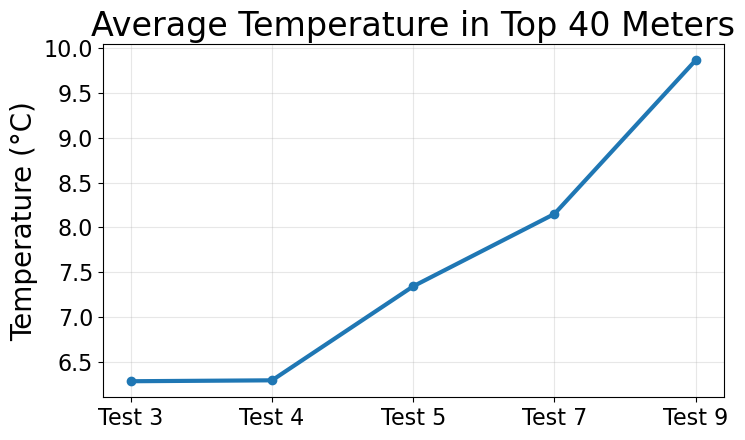

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --- Calculate average temperature in top 40 meters ---
temp_results = []

temp_results = []  # List to hold results for each test

for label, df in dfs.items():  # Loop through each test and its corresponding dataframe
    fname = test_files[label]  # Get the filename associated with the current test
    date_str = fname.split("T")[0]  # Extract just the date portion (e.g., "2025-05-28") from filename
    dt = datetime.strptime(date_str, "%Y-%m-%d")  # Convert date string to a datetime object

    mask_top_40 = (df["slowBRDepth"] >= 0) & (df["slowBRDepth"] <= 40)  # Create a mask for depths 0–40 meters
    top_40_temp_mean = df.loc[mask_top_40, "fastBRTemp"].mean()  # Calculate mean temperature in the top 40 meters

    temp_results.append({  # Store results as a dictionary in the results list
        "Test": label,     # Name of the test
        "Date": dt,        # Date of the test
        "Top40_Temp": top_40_temp_mean  # Mean temp in top 40 m
    })

# Convert to DataFrame and sort
temp_df = pd.DataFrame(temp_results).sort_values("Date")

# --- Plot ---
plt.figure(figsize=(7.5, 4.5))

plt.plot(
    temp_df["Test"],
    temp_df["Top40_Temp"],
    marker='o',
    linewidth=3
)

plt.title("Average Temperature in Top 40 Meters", fontsize=24)
plt.ylabel("Temperature (°C)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("allTests_temp_top40.jpg", dpi=600)
plt.show()